In [28]:
import numpy as np

# Load the uploaded .npy file to inspect the data
file_path = 'Datos/surrogates_2.npy'
surrogates_data = np.load(file_path)

surrogates_data


array([[-1.39064409, -0.36494998, -0.93937248, ..., -0.58756117,
        -0.79724463, -1.09487855],
       [-1.08351627, -1.03684857, -0.83887788, ..., -1.07026143,
        -0.84462353, -1.08616911],
       [-0.98021973, -1.1491753 , -1.20774606, ..., -0.90040616,
        -1.27094937, -1.4314156 ],
       ...,
       [ 1.60188335,  1.55263611,  1.56342917, ...,  1.52548887,
         1.58683243,  1.51231073],
       [ 1.57504361,  1.55000212,  1.57778351, ...,  1.56468875,
         1.56619742,  1.54563568],
       [ 1.58993364,  1.61289865,  1.56003124, ...,  1.67472211,
         1.6998899 ,  1.63190355]])

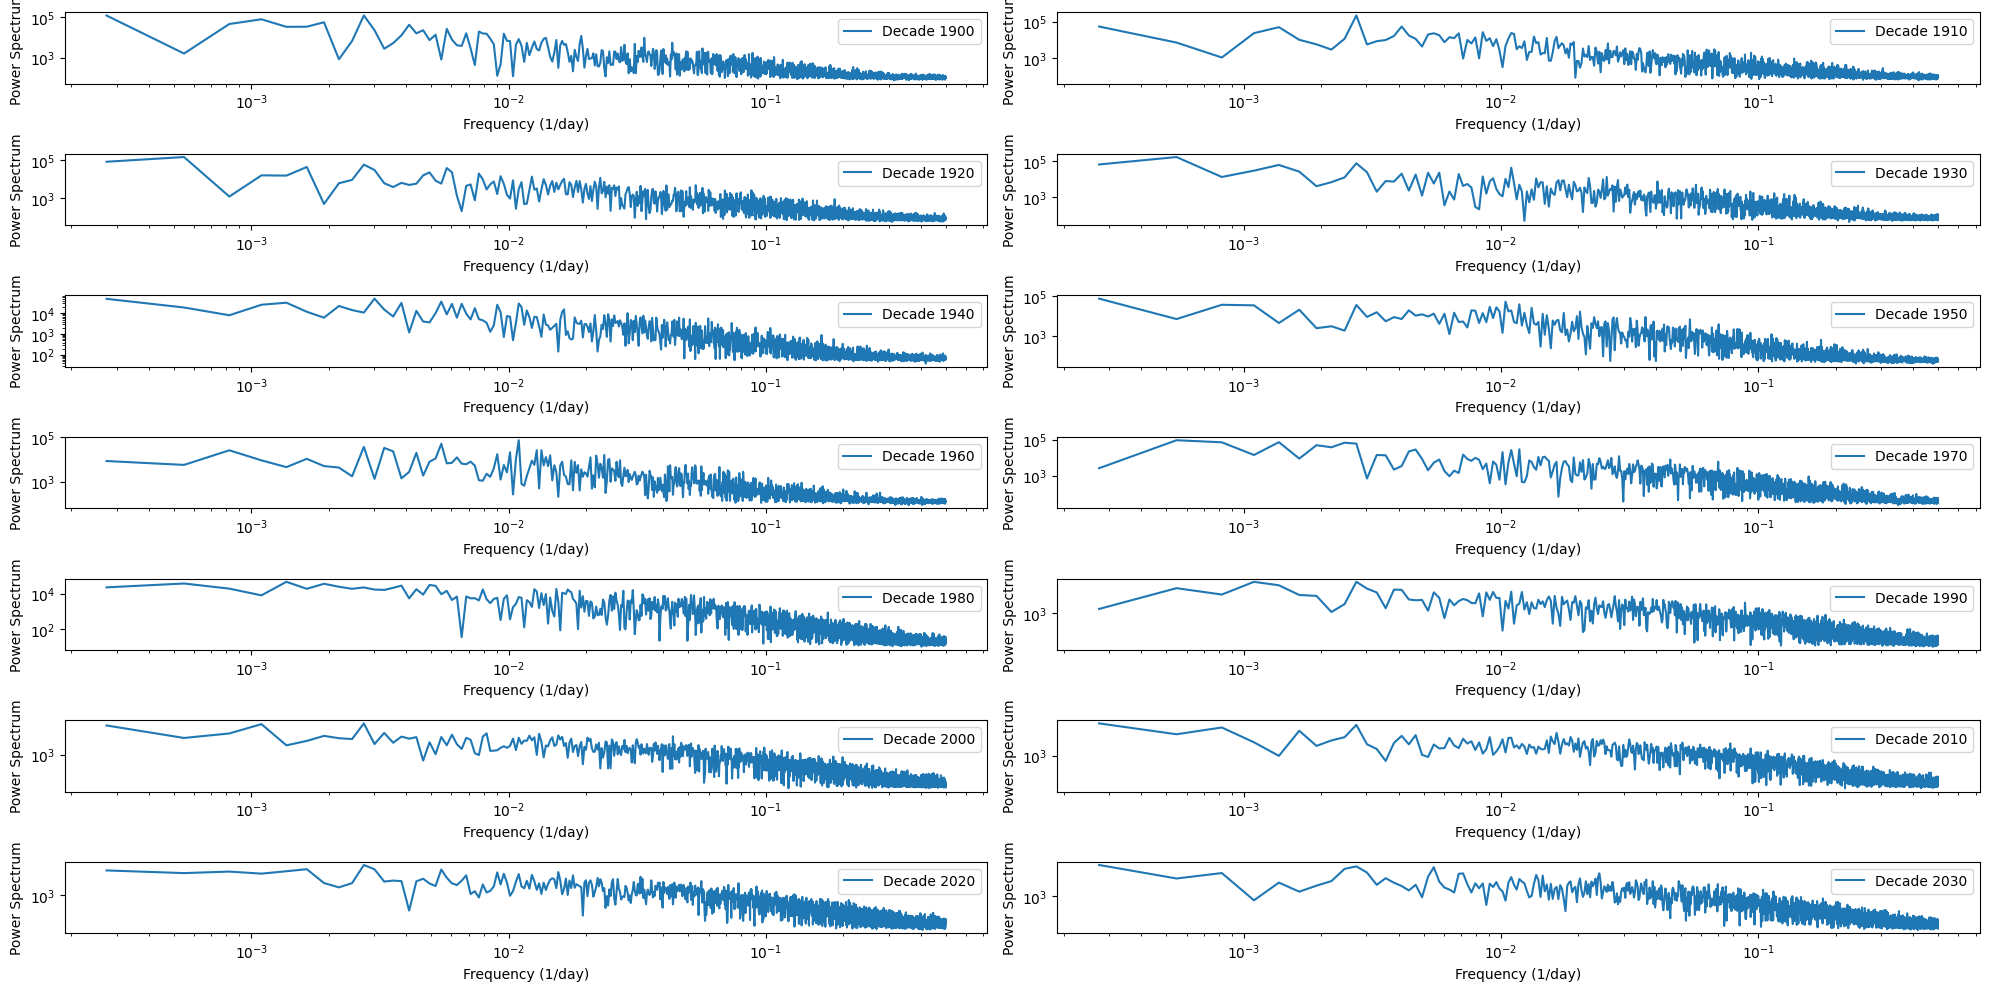

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Asumiendo que surrogates_data es tu array de datos (52,053 días y 100 columnas de subrogados)
n_days, n_surrogates = surrogates_data.shape
n_decades = n_days // 3650  # Aproximadamente una década

# Inicializar listas para guardar los resultados
slopes_segment_1 = []
slopes_segment_2 = []

plt.figure(figsize=(20, 10))

for i in range(n_decades):
    start_idx = i * 3650
    end_idx = start_idx + 3650
    decade_data = surrogates_data[start_idx:end_idx, :]

    # Calcular el espectro de potencia para cada subrogado en la década
    power_spectra = []
    for surrogate in range(n_surrogates):
        fft_result = np.fft.fft(decade_data[:, surrogate])
        power_spectrum = np.abs(fft_result) ** 2
        frequencies = np.fft.fftfreq(len(fft_result), d=1)
        positive_freqs = frequencies > 0
        power_spectra.append(power_spectrum[positive_freqs])

    # Media del espectro de potencia
    avg_power_spectrum = np.mean(power_spectra, axis=0)

    # Graficar el espectro de potencia medio
    plt.subplot(n_decades // 2, 2, i + 1)
    plt.loglog(frequencies[positive_freqs], avg_power_spectrum, label='Decade {}'.format(1900 + i * 10))
    plt.xlabel('Frequency (1/day)')
    plt.ylabel('Power Spectrum')
    plt.legend()

plt.tight_layout()
plt.show()


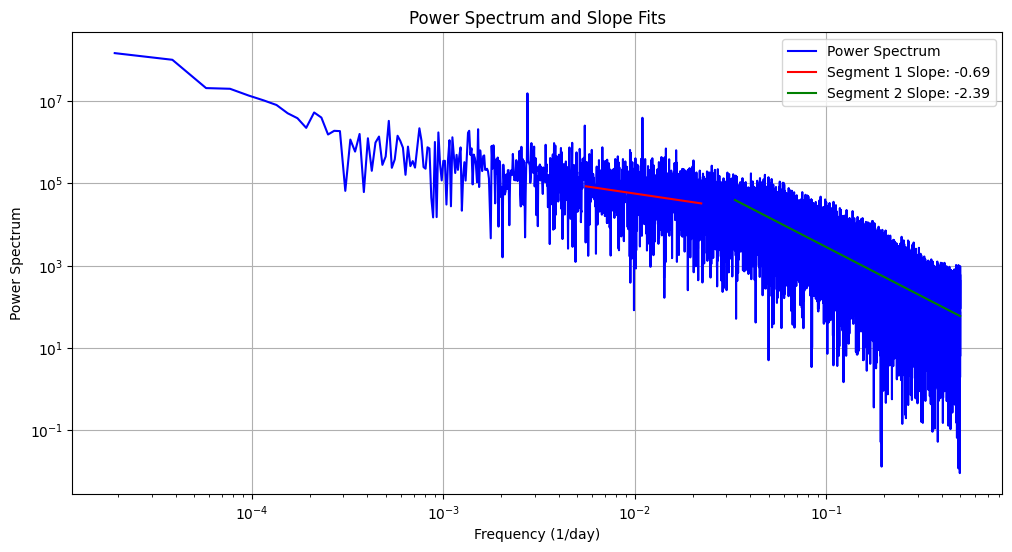

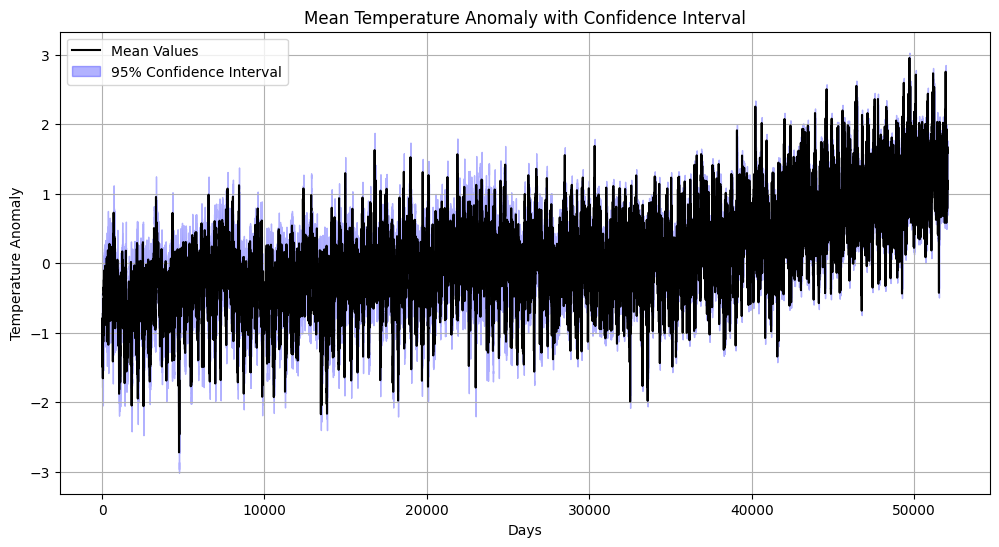

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Paso 1: Calcular el valor más probable (media) y los intervalos de confianza (2 std dev)
mean_values = np.mean(surrogates_data, axis=1)
std_dev_values = np.std(surrogates_data, axis=1)

# Calcular intervalos de confianza
lower_bound = mean_values - 2 * std_dev_values
upper_bound = mean_values + 2 * std_dev_values

# Paso 2: Calcular el espectro de potencia para el valor medio
n_days = len(mean_values)
fft_result = np.fft.fft(mean_values)
frequencies = np.fft.fftfreq(n_days, d=1)
positive_freqs = frequencies > 0
power_spectrum = np.abs(fft_result) ** 2
power_spectrum = power_spectrum[positive_freqs]
frequencies = frequencies[positive_freqs]

# Paso 3: Calcular las pendientes para dos segmentos de frecuencia
# Segmento 1: Frecuencias de 1.5 a 6 meses (~45 a ~180 días)
freq_45_days = 1 / 45
freq_180_days = 1 / 180
index_45_days = np.argmin(np.abs(frequencies - freq_45_days))
index_180_days = np.argmin(np.abs(frequencies - freq_180_days))

# Log-log fit for segment 1
log_freq_1 = np.log10(frequencies[index_180_days:index_45_days])
log_power_1 = np.log10(power_spectrum[index_180_days:index_45_days])
slope_1, intercept_1 = np.polyfit(log_freq_1, log_power_1, 1)

# Segmento 2: Frecuencias de 1 día a 1 mes (~1 a ~30 días)
freq_1_day = 1 / 1
freq_30_days = 1 / 30
index_1_day = np.argmin(np.abs(frequencies - freq_1_day))
index_30_days = np.argmin(np.abs(frequencies - freq_30_days))

# Log-log fit for segment 2
log_freq_2 = np.log10(frequencies[index_30_days:index_1_day])
log_power_2 = np.log10(power_spectrum[index_30_days:index_1_day])
slope_2, intercept_2 = np.polyfit(log_freq_2, log_power_2, 1)

# Paso 4: Visualización
plt.figure(figsize=(12, 6))

# Gráfico del espectro de potencia
plt.loglog(frequencies, power_spectrum, label='Power Spectrum', color='blue')

# Ajuste log-log para los segmentos
plt.loglog(frequencies[index_180_days:index_45_days],
           10**(intercept_1 + slope_1 * log_freq_1), 'r-', label=f'Segment 1 Slope: {slope_1:.2f}')
plt.loglog(frequencies[index_30_days:index_1_day],
           10**(intercept_2 + slope_2 * log_freq_2), 'g-', label=f'Segment 2 Slope: {slope_2:.2f}')

plt.xlabel('Frequency (1/day)')
plt.ylabel('Power Spectrum')
plt.title('Power Spectrum and Slope Fits')
plt.legend()
plt.grid(True)
plt.show()

# Paso 5: Visualizar el valor medio y los intervalos de confianza
plt.figure(figsize=(12, 6))
plt.plot(mean_values, label='Mean Values', color='black')
plt.fill_between(range(n_days), lower_bound, upper_bound, color='blue', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Days')
plt.ylabel('Temperature Anomaly')
plt.title('Mean Temperature Anomaly with Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()


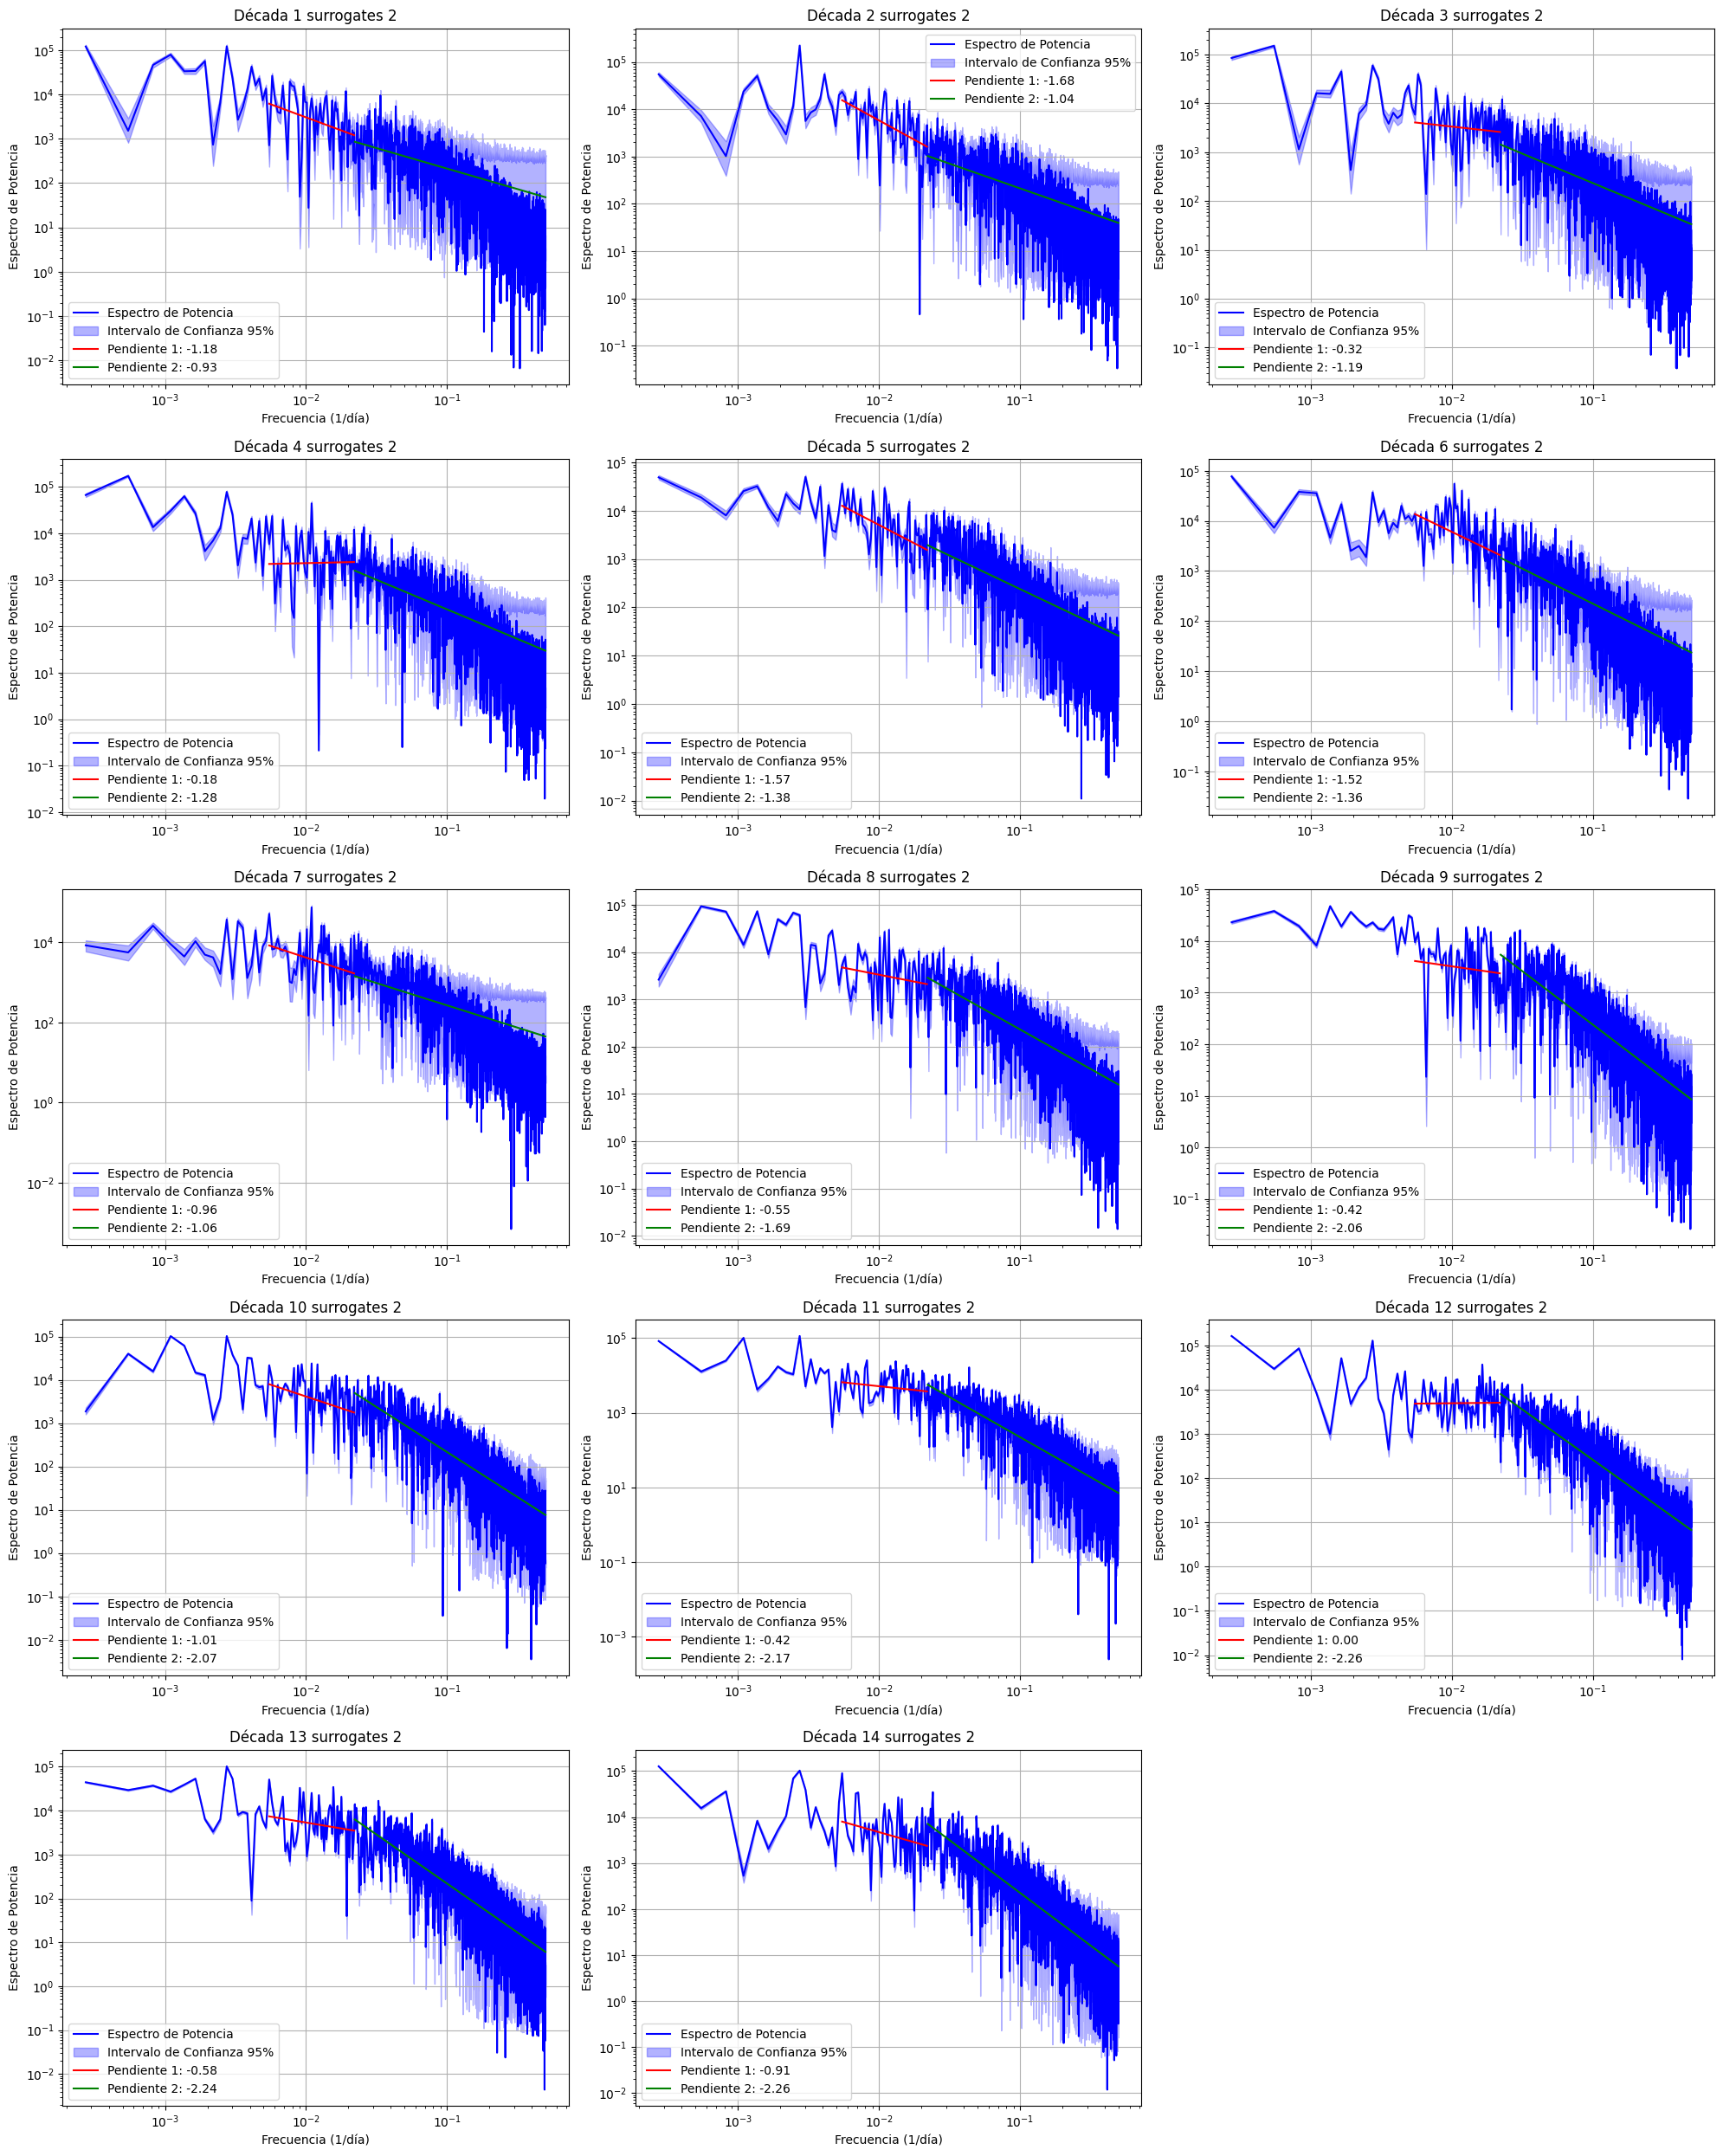

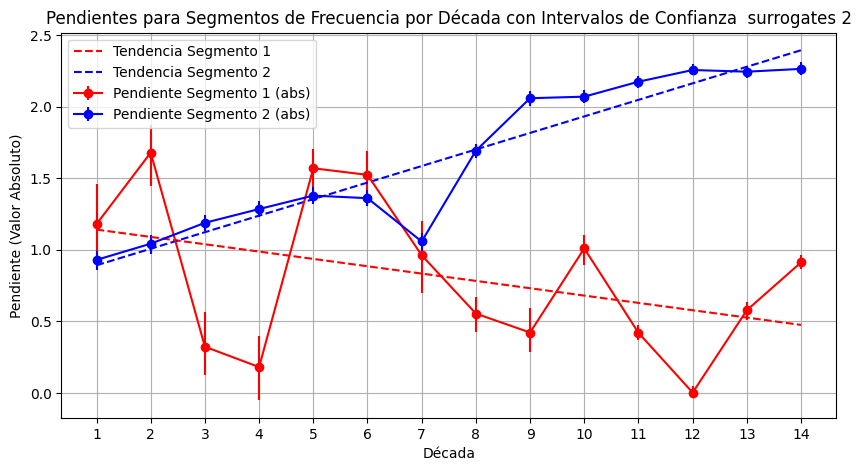

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Asumiendo que surrogates_data es tu array de datos (52,053 días y 100 columnas de subrogados)
n_days, n_surrogates = surrogates_data.shape
days_per_decade = 3650
n_decades = n_days // days_per_decade

# Número de gráficas por fila
plots_per_row = 3

# Calcular el número total de filas necesarias
total_rows = math.ceil(n_decades / plots_per_row)

# Inicializar listas para guardar las pendientes y sus intervalos de confianza por década
decade_slopes_segment_1_mean = []
decade_slopes_segment_1_lower = []
decade_slopes_segment_1_upper = []

decade_slopes_segment_2_mean = []
decade_slopes_segment_2_lower = []
decade_slopes_segment_2_upper = []

plt.figure(figsize=(20, total_rows * 5))

for i in range(n_decades):
    start_idx = i * days_per_decade
    end_idx = start_idx + days_per_decade
    decade_data = surrogates_data[start_idx:end_idx, :]

    # Calcular el valor más probable (media) y los intervalos de confianza
    mean_values = np.mean(decade_data, axis=1)
    std_dev_values = np.std(decade_data, axis=1)
    lower_bound = mean_values - 2 * std_dev_values
    upper_bound = mean_values + 2 * std_dev_values

    # Calcular el espectro de potencia para el valor medio
    fft_result = np.fft.fft(mean_values)
    frequencies = np.fft.fftfreq(len(fft_result), d=1)
    positive_freqs = frequencies > 0
    power_spectrum = np.abs(fft_result) ** 2
    power_spectrum = power_spectrum[positive_freqs]
    frequencies = frequencies[positive_freqs]

    # Generar realizaciones aleatorias basadas en la desviación estándar
    n_realizations = 200
    random_anomalies = np.random.normal(loc=mean_values[:, np.newaxis], scale=std_dev_values[:, np.newaxis], size=(days_per_decade, n_realizations))
    power_spectra = []

    # Listas para almacenar las pendientes de cada realización
    slopes_segment_1_realizations = []
    slopes_segment_2_realizations = []

    for j in range(n_realizations):
        realization_fft = np.fft.fft(random_anomalies[:, j])
        realization_power_spectrum = np.abs(realization_fft) ** 2
        power_spectra.append(realization_power_spectrum[positive_freqs])

        # Calcular las pendientes para las dos bandas de frecuencia
        freq_45_days = 1 / 45
        freq_180_days = 1 / 180
        index_45_days = np.argmin(np.abs(frequencies - freq_45_days))
        index_180_days = np.argmin(np.abs(frequencies - freq_180_days))
        log_freq_1 = np.log10(frequencies[index_180_days:index_45_days])
        log_power_1 = np.log10(realization_power_spectrum[positive_freqs][index_180_days:index_45_days])
        slope_1, intercept_1 = np.polyfit(log_freq_1, log_power_1, 1)
        slopes_segment_1_realizations.append(slope_1)

        freq_1_day = 1 / 1
        freq_30_days = 1 / 45
        index_1_day = np.argmin(np.abs(frequencies - freq_1_day))
        index_30_days = np.argmin(np.abs(frequencies - freq_30_days))
        log_freq_2 = np.log10(frequencies[index_30_days:index_1_day])
        log_power_2 = np.log10(realization_power_spectrum[positive_freqs][index_30_days:index_1_day])
        slope_2, intercept_2 = np.polyfit(log_freq_2, log_power_2, 1)
        slopes_segment_2_realizations.append(slope_2)

    power_spectra = np.array(power_spectra)
    lower_confidence = np.percentile(power_spectra, 2.5, axis=0)
    upper_confidence = np.percentile(power_spectra, 97.5, axis=0)

    # Calcular los intervalos de confianza para las pendientes
    slope_1_mean = np.mean(slopes_segment_1_realizations)
    slope_1_lower = np.percentile(slopes_segment_1_realizations, 2.5)
    slope_1_upper = np.percentile(slopes_segment_1_realizations, 97.5)

    slope_2_mean = np.mean(slopes_segment_2_realizations)
    slope_2_lower = np.percentile(slopes_segment_2_realizations, 2.5)
    slope_2_upper = np.percentile(slopes_segment_2_realizations, 97.5)

    # Almacenar los valores medios y los intervalos de confianza
    decade_slopes_segment_1_mean.append(slope_1_mean)
    decade_slopes_segment_1_lower.append(slope_1_lower)
    decade_slopes_segment_1_upper.append(slope_1_upper)

    decade_slopes_segment_2_mean.append(slope_2_mean)
    decade_slopes_segment_2_lower.append(slope_2_lower)
    decade_slopes_segment_2_upper.append(slope_2_upper)

    # Gráfico del espectro de potencia
    ax = plt.subplot(total_rows, plots_per_row, i + 1)
    ax.loglog(frequencies, power_spectrum, label='Espectro de Potencia', color='blue')
    ax.fill_between(frequencies, lower_confidence, upper_confidence, color='blue', alpha=0.3, label='Intervalo de Confianza 95%')
    ax.loglog(frequencies[index_180_days:index_45_days],
               10**(intercept_1 + slope_1 * log_freq_1), 'r-', label=f'Pendiente 1: {slope_1_mean:.2f}')
    ax.loglog(frequencies[index_30_days:index_1_day],
               10**(intercept_2 + slope_2 * log_freq_2), 'g-', label=f'Pendiente 2: {slope_2_mean:.2f}')
    ax.set_title(f'Década {i + 1} surrogates 2')
    ax.set_xlabel('Frecuencia (1/día)')
    ax.set_ylabel('Espectro de Potencia')
    ax.legend() 
    ax.grid(True)

plt.tight_layout()
plt.show()

# Visualización de las pendientes por década con intervalos de confianza
plt.figure(figsize=(10, 5))
decades = np.arange(1, n_decades + 1)

# Convertir listas a arrays para operaciones matemáticas
decade_slopes_segment_1_mean = np.array(decade_slopes_segment_1_mean)
decade_slopes_segment_1_lower = np.array(decade_slopes_segment_1_lower)
decade_slopes_segment_1_upper = np.array(decade_slopes_segment_1_upper)

decade_slopes_segment_2_mean = np.array(decade_slopes_segment_2_mean)
decade_slopes_segment_2_lower = np.array(decade_slopes_segment_2_lower)
decade_slopes_segment_2_upper = np.array(decade_slopes_segment_2_upper)

# Calcular los errores para las barras de error antes de tomar el valor absoluto
errors_segment_1 = [decade_slopes_segment_1_mean - decade_slopes_segment_1_lower,
                    decade_slopes_segment_1_upper - decade_slopes_segment_1_mean]

errors_segment_2 = [decade_slopes_segment_2_mean - decade_slopes_segment_2_lower,
                    decade_slopes_segment_2_upper - decade_slopes_segment_2_mean]

# Tomar el valor absoluto de las pendientes medias para graficar
decade_slopes_segment_1_mean_abs = np.abs(decade_slopes_segment_1_mean)
decade_slopes_segment_2_mean_abs = np.abs(decade_slopes_segment_2_mean)

# Graficar las pendientes con barras de error
plt.errorbar(decades, decade_slopes_segment_1_mean_abs, yerr=errors_segment_1, fmt='ro-', label='Pendiente Segmento 1 (abs)')
plt.errorbar(decades, decade_slopes_segment_2_mean_abs, yerr=errors_segment_2, fmt='bo-', label='Pendiente Segmento 2 (abs)')

# Agregar líneas de tendencia
# Para Segmento 1
coeffs_segment_1 = np.polyfit(decades, decade_slopes_segment_1_mean_abs, 1)
trendline_segment_1 = np.poly1d(coeffs_segment_1)
plt.plot(decades, trendline_segment_1(decades), 'r--', label='Tendencia Segmento 1')

# Para Segmento 2
coeffs_segment_2 = np.polyfit(decades, decade_slopes_segment_2_mean_abs, 1)
trendline_segment_2 = np.poly1d(coeffs_segment_2)
plt.plot(decades, trendline_segment_2(decades), 'b--', label='Tendencia Segmento 2')

plt.xlabel('Década')
plt.ylabel('Pendiente (Valor Absoluto)')
plt.title('Pendientes para Segmentos de Frecuencia por Década con Intervalos de Confianza  surrogates 2')
plt.legend()
plt.grid(True)
plt.xticks(decades)
plt.show()
